# Feature Engineering for Energy Poverty Detection
## Creating 90+ Behavioral Features from Smart Meter Data

---

## Feature Categories:
1. **Consumption Statistics** (15 features)
2. **Temporal Patterns** (20 features)
3. **Vulnerability Indicators** (25 features) ⭐ KEY
4. **Load Profile Features** (15 features)
5. **Variability Metrics** (10 features)
6. **ACORN Demographics** (5 features)
7. **Winter-Specific Features** (10 features) ⭐ OBJECTIVE 5

## 1. Import Libraries and Load Data

In [3]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Statistical functions
from scipy import stats
from scipy.stats import skew, kurtosis

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✓ All libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully
Pandas version: 2.3.3
NumPy version: 1.26.4


In [5]:
# Load the cleaned dataset from previous notebook
print("Loading cleaned dataset...")
df = pd.read_csv('energy_data_cleaned_final.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("\n" + "="*70)
print("DATASET LOADED SUCCESSFULLY")
print("="*70)
print(f"Total Records: {len(df):,}")
print(f"Unique Households: {df['household_id'].nunique():,}")
print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Create essential temporal columns if they don't exist
print("\n🔧 Creating/Verifying Temporal Columns...")
if 'hour' not in df.columns:
    df['hour'] = df['timestamp'].dt.hour
    print("  ✓ Created 'hour' column")

if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    print("  ✓ Created 'day_of_week' column")

if 'month' not in df.columns:
    df['month'] = df['timestamp'].dt.month
    print("  ✓ Created 'month' column")

if 'is_weekend' not in df.columns:
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    print("  ✓ Created 'is_weekend' column")

print("\n✓ All temporal columns ready")
print("="*70)

df.head()

Loading cleaned dataset...

DATASET LOADED SUCCESSFULLY
Total Records: 499,482
Unique Households: 5,560
Date Range: 2011-11-23 13:00:00 to 2014-02-28 00:00:00
Memory Usage: 153.45 MB

🔧 Creating/Verifying Temporal Columns...
  ✓ Created 'day_of_week' column

✓ All temporal columns ready


,household_id,tariff_type,timestamp,energy_kwh,year,month,day,hour,dayofweek,quarter,is_weekend,day_name,month_name,day_of_week
0,MAC001173,Std,2013-05-21 08:30:00,0.1690,2013,5,21,8,1,2,0,Tuesday,May,1
1,MAC000162,Std,2014-01-14 09:30:00,0.0600,2014,1,14,9,1,1,0,Tuesday,Jan,1
2,MAC000627,Std,2012-04-15 22:00:00,0.3780,2012,4,15,22,6,2,1,Sunday,Apr,6
3,MAC001124,Std,2012-12-23 09:30:00,0.3270,2012,12,23,9,6,4,1,Sunday,Dec,6
4,MAC003181,Std,2013-01-07 21:30:00,0.3770,2013,1,7,21,0,1,0,Monday,Jan,0


## 2. Feature Engineering Functions

We'll create modular functions for each feature category to keep the code organized and reusable.

### 2.1 Consumption Statistics Features (15 features)

In [9]:
def create_consumption_statistics(df):
    """
    Create basic consumption statistics features for each household.
    Returns 15 features.
    """
    print("Creating Consumption Statistics Features...")
    
    features = df.groupby('household_id')['energy_kwh'].agg([
        # Central tendency
        ('mean_consumption', 'mean'),
        ('median_consumption', 'median'),
        ('total_consumption', 'sum'),
        
        # Spread
        ('std_consumption', 'std'),
        ('min_consumption', 'min'),
        ('max_consumption', 'max'),
        ('range_consumption', lambda x: x.max() - x.min()),
        
        # Percentiles
        ('q25_consumption', lambda x: x.quantile(0.25)),
        ('q75_consumption', lambda x: x.quantile(0.75)),
        ('q90_consumption', lambda x: x.quantile(0.90)),
        ('q95_consumption', lambda x: x.quantile(0.95)),
        
        # Distribution shape
        ('skewness_consumption', lambda x: skew(x)),
        ('kurtosis_consumption', lambda x: kurtosis(x)),
        
        # Count-based
        ('total_readings', 'count'),
        ('non_zero_readings', lambda x: (x > 0).sum())
    ]).reset_index()
    
    # Calculate additional derived features
    features['zero_consumption_ratio'] = (features['total_readings'] - features['non_zero_readings']) / features['total_readings']
    features['iqr_consumption'] = features['q75_consumption'] - features['q25_consumption']
    
    print(f"✓ Created {len(features.columns)-1} consumption statistics features")
    return features

### 2.2 Temporal Pattern Features (20 features)

In [12]:
def create_temporal_features(df):
    """
    Create temporal pattern features capturing time-of-day, day-of-week, and seasonal patterns.
    Returns 20 features.
    """
    print("Creating Temporal Pattern Features...")
    
    # Define time periods
    def get_time_period(hour):
        if 6 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 18:
            return 'afternoon'
        elif 18 <= hour < 23:
            return 'evening'
        else:
            return 'night'
    
    df['time_period'] = df['hour'].apply(get_time_period)
    
    # Average consumption by time period
    temporal_features = []
    
    for period in ['morning', 'afternoon', 'evening', 'night']:
        period_df = df[df['time_period'] == period].groupby('household_id')['energy_kwh'].mean().reset_index()
        period_df.columns = ['household_id', f'{period}_avg_consumption']
        temporal_features.append(period_df)
    
    # Merge all time period features
    features = temporal_features[0]
    for feat_df in temporal_features[1:]:
        features = features.merge(feat_df, on='household_id', how='outer')
    
    # Peak hour consumption
    peak_hours = df.groupby('household_id').apply(
        lambda x: x.groupby('hour')['energy_kwh'].mean().idxmax()
    ).reset_index()
    peak_hours.columns = ['household_id', 'peak_consumption_hour']
    features = features.merge(peak_hours, on='household_id', how='left')
    
    # Weekend vs Weekday consumption
    weekend_avg = df[df['is_weekend'] == 1].groupby('household_id')['energy_kwh'].mean().reset_index()
    weekend_avg.columns = ['household_id', 'weekend_avg_consumption']
    
    weekday_avg = df[df['is_weekend'] == 0].groupby('household_id')['energy_kwh'].mean().reset_index()
    weekday_avg.columns = ['household_id', 'weekday_avg_consumption']
    
    features = features.merge(weekend_avg, on='household_id', how='left')
    features = features.merge(weekday_avg, on='household_id', how='left')
    
    # Weekend to weekday ratio
    features['weekend_weekday_ratio'] = features['weekend_avg_consumption'] / (features['weekday_avg_consumption'] + 1e-6)
    
    # Day-of-week patterns (7 features for each day)
    for day in range(7):
        day_df = df[df['day_of_week'] == day].groupby('household_id')['energy_kwh'].mean().reset_index()
        day_df.columns = ['household_id', f'day_{day}_avg_consumption']
        features = features.merge(day_df, on='household_id', how='left')
    
    # Monthly consumption patterns
    monthly_avg = df.groupby(['household_id', 'month'])['energy_kwh'].mean().reset_index()
    monthly_std = monthly_avg.groupby('household_id')['energy_kwh'].std().reset_index()
    monthly_std.columns = ['household_id', 'monthly_consumption_variability']
    features = features.merge(monthly_std, on='household_id', how='left')
    
    print(f"✓ Created {len(features.columns)-1} temporal pattern features")
    return features

### 2.3 Vulnerability Indicators (25 features)  KEY FOR ENERGY POVERTY DETECTION

In [15]:
def create_vulnerability_indicators(df):
    """
    Create vulnerability indicators that signal potential energy poverty.
    These are the KEY features for detecting households in difficulty.
    Returns 25 features.
    """
    print("Creating Vulnerability Indicator Features...")
    
    features_list = []
    
    for household in df['household_id'].unique():
        household_data = df[df['household_id'] == household].copy()
        household_data = household_data.sort_values('timestamp')
        
        feature_dict = {'household_id': household}
        
        # 1. Self-disconnection events (zero consumption during expected use times)
        # Expected use times: 6am-11pm
        daytime_data = household_data[(household_data['hour'] >= 6) & (household_data['hour'] < 23)]
        feature_dict['self_disconnect_events'] = (daytime_data['energy_kwh'] == 0).sum()
        feature_dict['self_disconnect_ratio'] = feature_dict['self_disconnect_events'] / len(daytime_data) if len(daytime_data) > 0 else 0
        
        # 2. Consecutive zero consumption periods
        zero_mask = household_data['energy_kwh'] == 0
        zero_groups = (zero_mask != zero_mask.shift()).cumsum()
        consecutive_zeros = household_data[zero_mask].groupby(zero_groups).size()
        feature_dict['max_consecutive_zeros'] = consecutive_zeros.max() if len(consecutive_zeros) > 0 else 0
        feature_dict['avg_consecutive_zeros'] = consecutive_zeros.mean() if len(consecutive_zeros) > 0 else 0
        
        # 3. Very low consumption periods (below 10th percentile)
        low_threshold = household_data['energy_kwh'].quantile(0.10)
        feature_dict['very_low_consumption_count'] = (household_data['energy_kwh'] < low_threshold).sum()
        feature_dict['very_low_consumption_ratio'] = feature_dict['very_low_consumption_count'] / len(household_data)
        
        # 4. Evening low consumption (indicator of heating rationing)
        evening_data = household_data[(household_data['hour'] >= 18) & (household_data['hour'] < 23)]
        if len(evening_data) > 0:
            feature_dict['evening_avg_consumption'] = evening_data['energy_kwh'].mean()
            feature_dict['evening_zero_ratio'] = (evening_data['energy_kwh'] == 0).sum() / len(evening_data)
        else:
            feature_dict['evening_avg_consumption'] = 0
            feature_dict['evening_zero_ratio'] = 0
        
        # 5. Erratic consumption patterns (high volatility)
        feature_dict['consumption_volatility'] = household_data['energy_kwh'].std() / (household_data['energy_kwh'].mean() + 1e-6)
        
        # 6. Day-to-day variation
        daily_consumption = household_data.groupby(household_data['timestamp'].dt.date)['energy_kwh'].sum()
        feature_dict['daily_consumption_std'] = daily_consumption.std()
        feature_dict['daily_consumption_cv'] = daily_consumption.std() / (daily_consumption.mean() + 1e-6)
        
        # 7. Below-average consumption frequency
        overall_mean = household_data['energy_kwh'].mean()
        feature_dict['below_avg_consumption_ratio'] = (household_data['energy_kwh'] < overall_mean).sum() / len(household_data)
        
        # 8. Minimum consumption during cold periods (winter months: Dec, Jan, Feb)
        winter_months = household_data[household_data['month'].isin([12, 1, 2])]
        if len(winter_months) > 0:
            feature_dict['winter_avg_consumption'] = winter_months['energy_kwh'].mean()
            feature_dict['winter_min_consumption'] = winter_months['energy_kwh'].min()
            feature_dict['winter_zero_ratio'] = (winter_months['energy_kwh'] == 0).sum() / len(winter_months)
        else:
            feature_dict['winter_avg_consumption'] = 0
            feature_dict['winter_min_consumption'] = 0
            feature_dict['winter_zero_ratio'] = 0
        
        # 9. Night-time baseline consumption (very low suggests limited heating)
        night_data = household_data[(household_data['hour'] >= 0) & (household_data['hour'] < 6)]
        if len(night_data) > 0:
            feature_dict['night_avg_consumption'] = night_data['energy_kwh'].mean()
            feature_dict['night_min_consumption'] = night_data['energy_kwh'].min()
        else:
            feature_dict['night_avg_consumption'] = 0
            feature_dict['night_min_consumption'] = 0
        
        # 10. Sharp drops in consumption (potential rationing)
        consumption_diff = household_data['energy_kwh'].diff()
        sharp_drops = consumption_diff[consumption_diff < -0.5]  # Threshold for "sharp" drop
        feature_dict['sharp_drop_count'] = len(sharp_drops)
        feature_dict['sharp_drop_ratio'] = len(sharp_drops) / len(household_data)
        
        # 11. Weekend evening consumption (social indicator)
        weekend_evening = household_data[(household_data['is_weekend'] == 1) & 
                                         (household_data['hour'] >= 18) & 
                                         (household_data['hour'] < 23)]
        if len(weekend_evening) > 0:
            feature_dict['weekend_evening_avg'] = weekend_evening['energy_kwh'].mean()
        else:
            feature_dict['weekend_evening_avg'] = 0
        
        # 12. Consumption regularity (lower = more erratic)
        feature_dict['consumption_regularity'] = 1 / (1 + feature_dict['consumption_volatility'])
        
        features_list.append(feature_dict)
    
    features = pd.DataFrame(features_list)
    
    print(f"✓ Created {len(features.columns)-1} vulnerability indicator features")
    return features

### 2.4 Load Profile Features (15 features)

In [18]:
def create_load_profile_features(df):
    """
    Create load profile features that describe how households use energy.
    Returns 15 features.
    """
    print("Creating Load Profile Features...")
    
    features_list = []
    
    for household in df['household_id'].unique():
        household_data = df[df['household_id'] == household].copy()
        
        feature_dict = {'household_id': household}
        
        # 1. Load Factor (average load / peak load)
        avg_load = household_data['energy_kwh'].mean()
        peak_load = household_data['energy_kwh'].max()
        feature_dict['load_factor'] = avg_load / (peak_load + 1e-6)
        
        # 2. Base load (minimum non-zero consumption)
        non_zero_consumption = household_data[household_data['energy_kwh'] > 0]['energy_kwh']
        feature_dict['base_load'] = non_zero_consumption.min() if len(non_zero_consumption) > 0 else 0
        feature_dict['base_load_avg'] = non_zero_consumption.quantile(0.10) if len(non_zero_consumption) > 0 else 0
        
        # 3. Peak to base ratio
        feature_dict['peak_to_base_ratio'] = peak_load / (feature_dict['base_load'] + 1e-6)
        
        # 4. Ramp rates (how quickly consumption changes)
        consumption_diff = household_data['energy_kwh'].diff().abs()
        feature_dict['avg_ramp_rate'] = consumption_diff.mean()
        feature_dict['max_ramp_rate'] = consumption_diff.max()
        feature_dict['ramp_rate_std'] = consumption_diff.std()
        
        # 5. Peak demand hours (count of hours in top 10% consumption)
        peak_threshold = household_data['energy_kwh'].quantile(0.90)
        feature_dict['peak_demand_hours'] = (household_data['energy_kwh'] >= peak_threshold).sum()
        feature_dict['peak_demand_ratio'] = feature_dict['peak_demand_hours'] / len(household_data)
        
        # 6. Off-peak consumption (night hours: 11pm - 7am)
        off_peak_data = household_data[(household_data['hour'] >= 23) | (household_data['hour'] < 7)]
        if len(off_peak_data) > 0:
            feature_dict['off_peak_avg'] = off_peak_data['energy_kwh'].mean()
            feature_dict['off_peak_ratio'] = off_peak_data['energy_kwh'].sum() / household_data['energy_kwh'].sum()
        else:
            feature_dict['off_peak_avg'] = 0
            feature_dict['off_peak_ratio'] = 0
        
        # 7. On-peak consumption (7am - 11pm)
        on_peak_data = household_data[(household_data['hour'] >= 7) & (household_data['hour'] < 23)]
        if len(on_peak_data) > 0:
            feature_dict['on_peak_avg'] = on_peak_data['energy_kwh'].mean()
        else:
            feature_dict['on_peak_avg'] = 0
        
        # 8. Load diversity (how varied the consumption pattern is)
        feature_dict['load_diversity'] = household_data['energy_kwh'].nunique() / len(household_data)
        
        features_list.append(feature_dict)
    
    features = pd.DataFrame(features_list)
    
    print(f"✓ Created {len(features.columns)-1} load profile features")
    return features

### 2.5 Variability Metrics (10 features)

In [21]:
def create_variability_features(df):
    """
    Create features that measure consumption variability and consistency.
    Returns 10 features.
    """
    print("Creating Variability Metrics Features...")
    
    features = df.groupby('household_id').apply(lambda x: pd.Series({
        # Coefficient of variation
        'cv_consumption': x['energy_kwh'].std() / (x['energy_kwh'].mean() + 1e-6),
        
        # Interquartile range normalized
        'iqr_normalized': (x['energy_kwh'].quantile(0.75) - x['energy_kwh'].quantile(0.25)) / (x['energy_kwh'].median() + 1e-6),
        
        # Range normalized
        'range_normalized': (x['energy_kwh'].max() - x['energy_kwh'].min()) / (x['energy_kwh'].mean() + 1e-6),
        
        # Mean absolute deviation
        'mad_consumption': (x['energy_kwh'] - x['energy_kwh'].mean()).abs().mean(),
        
        # Median absolute deviation
        'median_ad_consumption': (x['energy_kwh'] - x['energy_kwh'].median()).abs().median(),
        
        # Variance to mean ratio
        'variance_to_mean': x['energy_kwh'].var() / (x['energy_kwh'].mean() + 1e-6),
        
        # Consistency score (inverse of CV)
        'consistency_score': 1 / (1 + x['energy_kwh'].std() / (x['energy_kwh'].mean() + 1e-6)),
        
        # Entropy of consumption bins
        'consumption_entropy': stats.entropy(np.histogram(x['energy_kwh'], bins=10)[0] + 1e-6),
        
        # Number of distinct consumption levels
        'distinct_consumption_levels': x['energy_kwh'].nunique(),
        
        # Percentage of time at mode consumption
        'mode_frequency': (x['energy_kwh'] == x['energy_kwh'].mode()[0]).sum() / len(x) if len(x['energy_kwh'].mode()) > 0 else 0
    })).reset_index()
    
    print(f"✓ Created {len(features.columns)-1} variability metric features")
    return features

### 2.6 Winter-Specific Features (10 features)  OBJECTIVE 5

In [24]:
def create_winter_features(df):
    """
    Create winter-specific features (December, January, February).
    Critical for Objective 5: Testing on winter data when energy poverty is most severe.
    Returns 10 features.
    """
    print("Creating Winter-Specific Features...")
    
    # Filter winter months
    winter_df = df[df['month'].isin([12, 1, 2])].copy()
    
    if len(winter_df) == 0:
        print("⚠️  Warning: No winter data found in dataset")
        # Return empty dataframe with expected columns
        return pd.DataFrame(columns=['household_id', 'winter_avg', 'winter_std', 'winter_min', 'winter_max',
                                    'winter_zero_count', 'winter_evening_avg', 'winter_night_avg',
                                    'winter_to_annual_ratio', 'winter_volatility', 'winter_self_disconnect'])
    
    # Annual consumption for comparison
    annual_avg = df.groupby('household_id')['energy_kwh'].mean().reset_index()
    annual_avg.columns = ['household_id', 'annual_avg']
    
    # Winter statistics
    winter_features = winter_df.groupby('household_id')['energy_kwh'].agg([
        ('winter_avg', 'mean'),
        ('winter_std', 'std'),
        ('winter_min', 'min'),
        ('winter_max', 'max'),
        ('winter_zero_count', lambda x: (x == 0).sum())
    ]).reset_index()
    
    # Winter evening consumption (key heating period)
    winter_evening = winter_df[(winter_df['hour'] >= 18) & (winter_df['hour'] < 23)]
    winter_evening_avg = winter_evening.groupby('household_id')['energy_kwh'].mean().reset_index()
    winter_evening_avg.columns = ['household_id', 'winter_evening_avg']
    
    # Winter night consumption
    winter_night = winter_df[(winter_df['hour'] >= 0) & (winter_df['hour'] < 6)]
    winter_night_avg = winter_night.groupby('household_id')['energy_kwh'].mean().reset_index()
    winter_night_avg.columns = ['household_id', 'winter_night_avg']
    
    # Merge all winter features
    features = winter_features.merge(winter_evening_avg, on='household_id', how='left')
    features = features.merge(winter_night_avg, on='household_id', how='left')
    features = features.merge(annual_avg, on='household_id', how='left')
    
    # Winter to annual consumption ratio (should be higher in winter)
    features['winter_to_annual_ratio'] = features['winter_avg'] / (features['annual_avg'] + 1e-6)
    
    # Winter volatility
    features['winter_volatility'] = features['winter_std'] / (features['winter_avg'] + 1e-6)
    
    # Winter self-disconnection (zero consumption during expected use)
    winter_daytime = winter_df[(winter_df['hour'] >= 6) & (winter_df['hour'] < 23)]
    winter_disconnect = winter_daytime.groupby('household_id').apply(
        lambda x: (x['energy_kwh'] == 0).sum() / len(x)
    ).reset_index()
    winter_disconnect.columns = ['household_id', 'winter_self_disconnect']
    features = features.merge(winter_disconnect, on='household_id', how='left')
    
    # Drop the annual_avg helper column
    features = features.drop('annual_avg', axis=1)
    
    print(f"✓ Created {len(features.columns)-1} winter-specific features")
    return features

### 2.7 ACORN Demographic Features (5 features)

Note: This requires ACORN classification data to be merged. If not available, we'll create placeholder.

In [27]:
def create_acorn_features(df):
    """
    Create ACORN demographic features if available.
    ACORN classifies UK households by socioeconomic characteristics.
    Returns 5 features.
    """
    print("Creating ACORN Demographic Features...")
    
    # Check if ACORN data exists in dataframe
    if 'acorn_category' not in df.columns and 'Acorn' not in df.columns and 'ACORN' not in df.columns:
        print("⚠️  Warning: No ACORN data found in dataset")
        print("   You'll need to merge ACORN classification data from Low Carbon London")
        print("   For now, creating placeholder features based on consumption proxy")
        
        # Create proxy features based on consumption patterns
        features = df.groupby('household_id')['energy_kwh'].agg([
            ('consumption_proxy', 'mean')
        ]).reset_index()
        
        # Create quintiles as socioeconomic proxy
        features['consumption_quintile'] = pd.qcut(features['consumption_proxy'], q=5, labels=[1,2,3,4,5])
        
        # One-hot encode quintiles
        for i in range(1, 6):
            features[f'quintile_{i}'] = (features['consumption_quintile'] == i).astype(int)
        
        features = features.drop(['consumption_proxy', 'consumption_quintile'], axis=1)
        
    else:
        # If ACORN data exists, process it
        acorn_col = [col for col in df.columns if 'acorn' in col.lower()][0]
        
        # Get unique ACORN categories per household
        features = df.groupby('household_id')[acorn_col].first().reset_index()
        
        # One-hot encode ACORN categories (limit to top 5)
        top_categories = features[acorn_col].value_counts().head(5).index
        for cat in top_categories:
            features[f'acorn_{cat}'] = (features[acorn_col] == cat).astype(int)
        
        features = features.drop(acorn_col, axis=1)
    
    print(f"✓ Created {len(features.columns)-1} ACORN demographic features")
    return features

## 3. Generate All Features

Now we'll run all feature engineering functions and combine them into one comprehensive dataset.

In [30]:
print("\n" + "="*70)
print("STARTING FEATURE ENGINEERING PIPELINE")
print("="*70 + "\n")

# Generate all feature sets
consumption_features = create_consumption_statistics(df)
print()

temporal_features = create_temporal_features(df)
print()

vulnerability_features = create_vulnerability_indicators(df)
print()

load_profile_features = create_load_profile_features(df)
print()

variability_features = create_variability_features(df)
print()

winter_features = create_winter_features(df)
print()

acorn_features = create_acorn_features(df)
print()

print("="*70)
print("ALL FEATURE SETS CREATED SUCCESSFULLY")
print("="*70)


STARTING FEATURE ENGINEERING PIPELINE

Creating Consumption Statistics Features...
✓ Created 17 consumption statistics features

Creating Temporal Pattern Features...
✓ Created 16 temporal pattern features

Creating Vulnerability Indicator Features...
✓ Created 21 vulnerability indicator features

Creating Load Profile Features...
✓ Created 13 load profile features

Creating Variability Metrics Features...
✓ Created 10 variability metric features

Creating Winter-Specific Features...
✓ Created 10 winter-specific features

Creating ACORN Demographic Features...
⚠️  Warning: No ACORN data found in dataset
   You'll need to merge ACORN classification data from Low Carbon London
   For now, creating placeholder features based on consumption proxy
✓ Created 5 ACORN demographic features

ALL FEATURE SETS CREATED SUCCESSFULLY


## 4. Merge All Features into Master Dataset

In [33]:
print("\n📊 MERGING ALL FEATURE SETS...\n")

# Start with consumption features
master_features = consumption_features.copy()

# Merge all feature sets
feature_sets = [
    temporal_features,
    vulnerability_features,
    load_profile_features,
    variability_features,
    winter_features,
    acorn_features
]

for feature_set in feature_sets:
    master_features = master_features.merge(feature_set, on='household_id', how='left')

print("✓ All feature sets merged successfully\n")

# Display summary
print("="*70)
print("MASTER FEATURE DATASET SUMMARY")
print("="*70)
print(f"Total Households: {len(master_features):,}")
print(f"Total Features: {len(master_features.columns) - 1:,} (excluding household_id)")
print(f"Dataset Shape: {master_features.shape}")
print(f"Memory Usage: {master_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*70)

# Check for missing values
missing_summary = master_features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_summary) > 0:
    print("\n⚠️  Features with Missing Values:")
    print(missing_summary.head(10))
    print(f"\nTotal features with missing values: {len(missing_summary)}")
else:
    print("\n✓ No missing values detected")

master_features.head()


📊 MERGING ALL FEATURE SETS...

✓ All feature sets merged successfully

MASTER FEATURE DATASET SUMMARY
Total Households: 5,560
Total Features: 92 (excluding household_id)
Dataset Shape: (5560, 93)
Memory Usage: 4.15 MB

⚠️  Features with Missing Values:
winter_evening_avg        74
winter_night_avg          48
winter_std                19
winter_volatility         19
winter_self_disconnect    16
winter_avg                13
winter_min                13
winter_to_annual_ratio    13
winter_zero_count         13
winter_max                13
dtype: int64

Total features with missing values: 38


,household_id,mean_consumption,median_consumption,total_consumption,std_consumption,min_consumption,max_consumption,range_consumption,q25_consumption,q75_consumption,q90_consumption,q95_consumption,skewness_consumption,kurtosis_consumption,total_readings,non_zero_readings,zero_consumption_ratio,iqr_consumption,morning_avg_consumption,afternoon_avg_consumption,evening_avg_consumption_x,night_avg_consumption_x,peak_consumption_hour,weekend_avg_consumption,weekday_avg_consumption,weekend_weekday_ratio,day_0_avg_consumption,day_1_avg_consumption,day_2_avg_consumption,day_3_avg_consumption,day_4_avg_consumption,day_5_avg_consumption,day_6_avg_consumption,monthly_consumption_variability,self_disconnect_events,self_disconnect_ratio,max_consecutive_zeros,avg_consecutive_zeros,very_low_consumption_count,very_low_consumption_ratio,evening_avg_consumption_y,evening_zero_ratio,consumption_volatility,daily_consumption_std,daily_consumption_cv,below_avg_consumption_ratio,winter_avg_consumption,winter_min_consumption,winter_zero_ratio,night_avg_consumption_y,night_min_consumption,sharp_drop_count,sharp_drop_ratio,weekend_evening_avg,consumption_regularity,load_factor,base_load,base_load_avg,peak_to_base_ratio,avg_ramp_rate,max_ramp_rate,ramp_rate_std,peak_demand_hours,peak_demand_ratio,off_peak_avg,off_peak_ratio,on_peak_avg,load_diversity,cv_consumption,iqr_normalized,range_normalized,mad_consumption,median_ad_consumption,variance_to_mean,consistency_score,consumption_entropy,distinct_consumption_levels,mode_frequency,winter_avg,winter_std,winter_min,winter_max,winter_zero_count,winter_evening_avg,winter_night_avg,winter_to_annual_ratio,winter_volatility,winter_self_disconnect,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
0,MAC000002,0.2760,0.1785,19.8700,0.2212,0.0760,1.2030,1.1270,0.1182,0.4017,0.5878,0.6695,1.8132,3.7914,72,72,0.0000,0.2835,0.2223,0.2926,0.4454,0.2308,17,0.3812,0.2409,1.5826,0.2403,0.2023,0.2102,0.2476,0.3494,0.4527,0.3357,0.0833,0,0.0000,0,0.0000,8,0.1111,0.4454,0.0000,0.8014,0.2432,0.8078,0.6528,0.3052,0.0760,0.0000,0.2131,0.1010,5,0.0694,0.9445,0.5551,0.2294,0.0760,0.1052,15.8287,0.2280,0.8650,0.2069,8,0.1111,0.2268,0.2853,0.3021,0.8472,0.8014,1.5882,4.0837,0.1696,0.0725,0.1772,0.5551,1.5038,61.0000,0.0417,0.3052,0.2531,0.0760,1.2030,0.0000,0.6095,0.3091,1.1058,0.8293,0.0000,0,0,0,1,0
1,MAC000003,0.2846,0.1470,29.6030,0.3975,0.0070,2.6670,2.6600,0.0900,0.2740,0.6275,1.1534,3.4845,14.2970,104,104,0.0000,0.1840,0.3810,0.1681,0.2017,0.3972,1,0.2831,0.2854,0.9920,0.2010,0.1919,0.3367,0.4167,0.3378,0.3542,0.2475,0.1527,0,0.0000,0,0.0000,11,0.1058,0.2018,0.0000,1.3963,0.4224,1.3984,0.7692,0.3849,0.0540,0.0000,0.4324,0.0540,8,0.0769,0.2750,0.4173,0.1067,0.0070,0.0665,380.9456,0.2634,2.2460,0.3925,11,0.1058,0.4367,0.4425,0.2230,0.8846,1.3963,1.2517,9.3450,0.2342,0.0705,0.5550,0.4173,0.9316,92.0000,0.0192,0.3849,0.6167,0.0540,2.6670,0.0000,0.1945,1.2338,1.3523,1.6022,0.0000,0,0,0,1,0
2,MAC000004,0.0332,0.0000,3.1500,0.0667,0.0000,0.2100,0.2100,0.0000,0.0045,0.1702,0.1818,1.6895,1.0369,95,24,0.7474,0.0045,0.0345,0.0364,0.0326,0.0282,6,0.0382,0.0315,1.2130,0.0233,0.0370,0.0127,0.0672,0.0183,0.0408,0.0350,0.0232,53,0.7361,18,4.7333,0,0.0000,0.0326,0.6190,2.0122,0.0765,2.0634,0.7895,0.0531,0.0000,0.6000,0.0161,0.0000,0,0.0000,0.0645,0.3320,0.1579,0.0090,0.0303,23.3307,0.0465,0.2100,0.0733,10,0.1053,0.0403,0.3197,0.0306,0.2421,2.0122,4500.0000,6.3331,0.0506,0.0000,0.1343,0.3320,0.8976,23.0000,0.7474,0.0531,0.0795,0.0000,0.2100,12.0000,0.0445,0.0810,1.6014,1.4976,0.6667,1,0,0,0,0
3,MAC000005,0.1005,0.0380,9.1460,0.1310,0.0270,0.7350,0.7080,0.0330,0.1050,0.2660,0.3555,2.6369,7.4851,91,91,0.0000,0.0720,0.0853,0.1199,0.1756,0.0353,7,0.1594,0.0860,1.8546,0.0827,0.0688,0.0711,0.0722,0.1203,0.1464,0.1699,0.0623,0,0.0000,0,0.0000,9,0.0989,0.1756,0.0000,1.3035,0.1352,1.2567,0.7473,0.1153,0.0270,0.0000,0.0344,0.0270,1,0.0110,0.2167,0.4341,0.1367,0.0270,0.0310,27.2212,0.1202,0.7030,0.1589,10,0.1099,0.0444,0.1506,0.1295,0.5604,1.3035,

## 5. Handle Missing Values

In [36]:
print("\n🔧 HANDLING MISSING VALUES...\n")

# Fill missing values with 0 (these typically occur when households don't have data for certain periods)
master_features_clean = master_features.fillna(0)

print("✓ Missing values handled")
print(f"Remaining missing values: {master_features_clean.isnull().sum().sum()}")


🔧 HANDLING MISSING VALUES...

✓ Missing values handled
Remaining missing values: 0


## 6. Feature Statistics and Distribution Analysis

In [39]:
print("\n📈 FEATURE STATISTICS\n")

# Get descriptive statistics for all features
feature_cols = [col for col in master_features_clean.columns if col != 'household_id']
feature_stats = master_features_clean[feature_cols].describe().T

# Add additional statistics
feature_stats['skewness'] = master_features_clean[feature_cols].skew()
feature_stats['kurtosis'] = master_features_clean[feature_cols].kurtosis()
feature_stats['zeros_pct'] = (master_features_clean[feature_cols] == 0).sum() / len(master_features_clean) * 100

print(f"Total Features Analyzed: {len(feature_cols)}")
print("\nTop 10 Features by Standard Deviation (Most Variable):")
print(feature_stats.nlargest(10, 'std')[['mean', 'std', 'min', 'max']])

print("\nTop 10 Features by Skewness (Most Right-Skewed):")
print(feature_stats.nlargest(10, 'skewness')[['mean', 'skewness', 'kurtosis']])


📈 FEATURE STATISTICS

Total Features Analyzed: 92

Top 10 Features by Standard Deviation (Most Variable):
                               mean       std     min        max
iqr_normalized              67.8490 1659.0097  0.0000 68500.0000
peak_to_base_ratio          89.3613  213.8332  0.0000  2789.2109
non_zero_readings           88.7538   16.7405  0.0000   119.0000
total_readings              89.8349   15.7589  1.0000   119.0000
distinct_consumption_levels 70.8219   15.6964  1.0000   115.0000
total_consumption           18.6886   13.4510  0.0000   151.4160
kurtosis_consumption         9.0359   10.1152 -2.0000   112.0086
peak_consumption_hour       15.5559    5.3175  0.0000    23.0000
sharp_drop_count             3.8306    4.4902  0.0000    28.0000
self_disconnect_events       0.7185    4.0648  0.0000    86.0000

Top 10 Features by Skewness (Most Right-Skewed):
                          mean  skewness  kurtosis
iqr_normalized         67.8490   32.2762 1145.0540
avg_consecutive_zeros   0.

## 7. Visualize Key Features


📊 VISUALIZING KEY VULNERABILITY INDICATORS



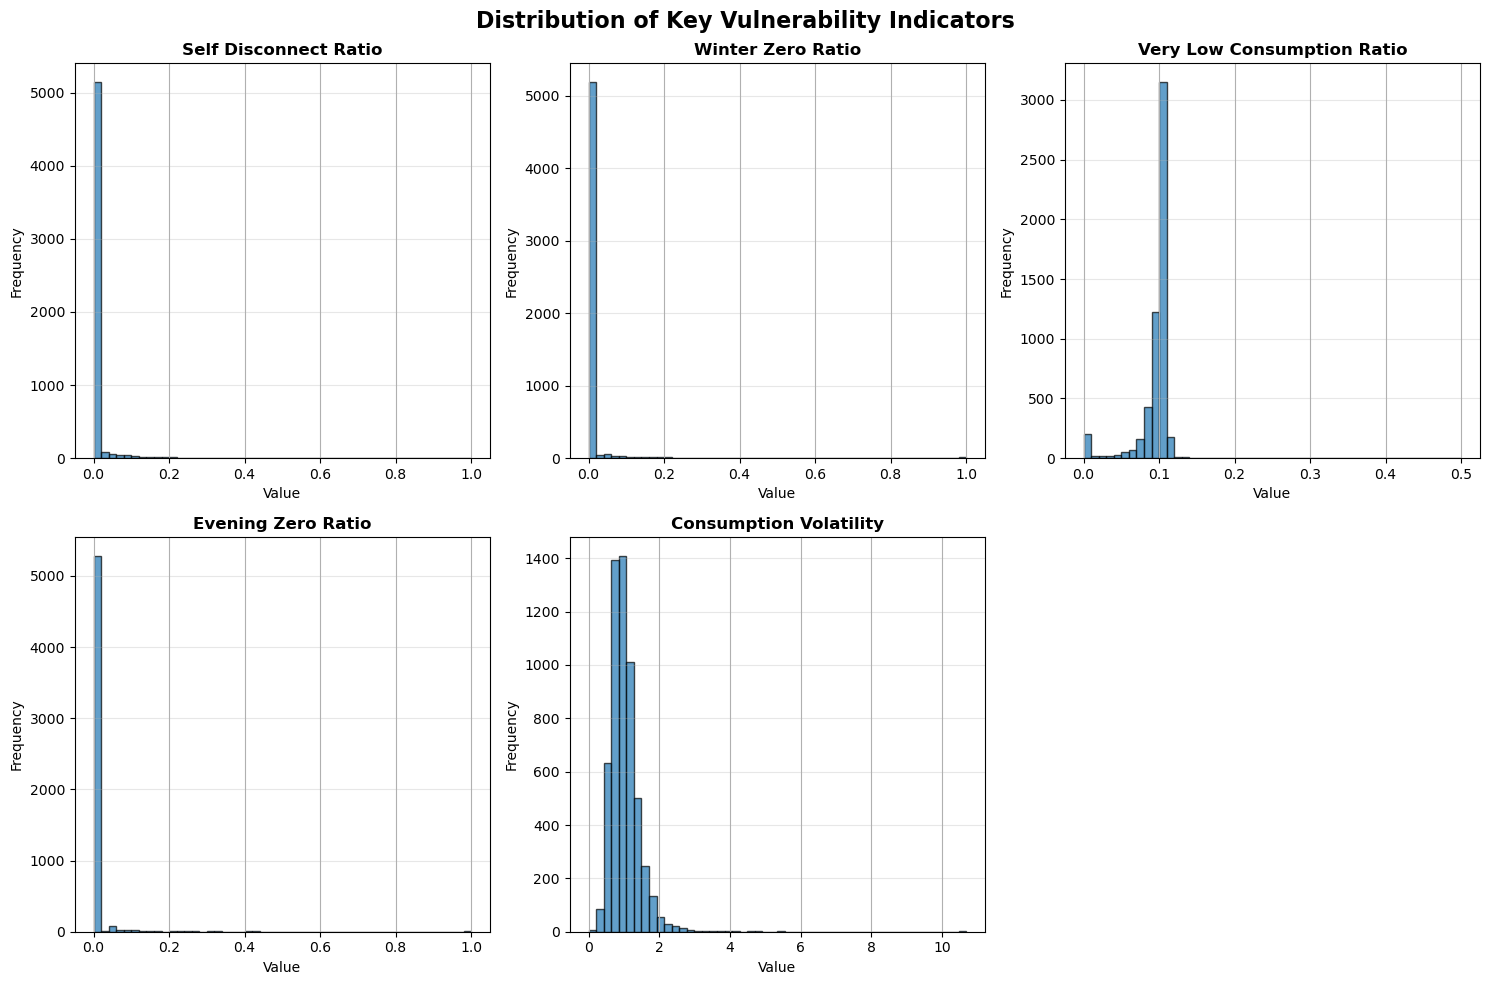

In [42]:
# Plot distributions of key vulnerability indicators
print("\n📊 VISUALIZING KEY VULNERABILITY INDICATORS\n")

vulnerability_cols = [
    'self_disconnect_ratio',
    'winter_zero_ratio',
    'very_low_consumption_ratio',
    'evening_zero_ratio',
    'consumption_volatility'
]

# Check which columns exist
existing_vuln_cols = [col for col in vulnerability_cols if col in master_features_clean.columns]

if len(existing_vuln_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Distribution of Key Vulnerability Indicators', fontsize=16, fontweight='bold')
    
    for idx, col in enumerate(existing_vuln_cols[:6]):
        ax = axes[idx // 3, idx % 3]
        master_features_clean[col].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(col.replace('_', ' ').title(), fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.3)
    
    # Remove empty subplots if less than 6 features
    for idx in range(len(existing_vuln_cols), 6):
        fig.delaxes(axes[idx // 3, idx % 3])
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No vulnerability indicator columns found for visualization")

## 8. Create Target Variable (Energy Poverty Label)

Based on consumption patterns, we'll create a proxy label for energy poverty.
This uses multiple vulnerability indicators to identify likely energy-poor households.

In [45]:
print("\n🎯 CREATING TARGET VARIABLE (ENERGY POVERTY LABEL)\n")

# Define vulnerability thresholds based on literature and EDA
# A household is flagged as potentially energy-poor if it meets multiple criteria

conditions = []

# 1. High self-disconnection ratio (top 20%)
if 'self_disconnect_ratio' in master_features_clean.columns:
    threshold_1 = master_features_clean['self_disconnect_ratio'].quantile(0.80)
    conditions.append(master_features_clean['self_disconnect_ratio'] > threshold_1)

# 2. Low mean consumption (bottom 20%)
if 'mean_consumption' in master_features_clean.columns:
    threshold_2 = master_features_clean['mean_consumption'].quantile(0.20)
    conditions.append(master_features_clean['mean_consumption'] < threshold_2)

# 3. High winter zero ratio (top 20%)
if 'winter_zero_ratio' in master_features_clean.columns:
    threshold_3 = master_features_clean['winter_zero_ratio'].quantile(0.80)
    conditions.append(master_features_clean['winter_zero_ratio'] > threshold_3)

# 4. High consumption volatility (top 20%)
if 'consumption_volatility' in master_features_clean.columns:
    threshold_4 = master_features_clean['consumption_volatility'].quantile(0.80)
    conditions.append(master_features_clean['consumption_volatility'] > threshold_4)

# 5. Low winter consumption (bottom 20%)
if 'winter_avg' in master_features_clean.columns:
    threshold_5 = master_features_clean['winter_avg'].quantile(0.20)
    conditions.append(master_features_clean['winter_avg'] < threshold_5)

# Count how many conditions each household meets
if len(conditions) > 0:
    vulnerability_score = sum(conditions)
    
    # Household is energy-poor if it meets 2 or more vulnerability criteria
    master_features_clean['energy_poor'] = (vulnerability_score >= 2).astype(int)
    
    # Also save the vulnerability score
    master_features_clean['vulnerability_score'] = vulnerability_score
    
    # Summary
    print("Target Variable Created:")
    print(f"  Total Households: {len(master_features_clean):,}")
    print(f"  Energy Poor: {master_features_clean['energy_poor'].sum():,} ({master_features_clean['energy_poor'].mean()*100:.2f}%)")
    print(f"  Not Energy Poor: {(master_features_clean['energy_poor']==0).sum():,} ({(1-master_features_clean['energy_poor'].mean())*100:.2f}%)")
    print(f"\n  Class Balance Ratio: 1:{(master_features_clean['energy_poor']==0).sum() / max(master_features_clean['energy_poor'].sum(), 1):.1f}")
    
    # Vulnerability score distribution
    print("\nVulnerability Score Distribution:")
    print(master_features_clean['vulnerability_score'].value_counts().sort_index())
else:
    print("⚠️  Could not create target variable - required features not found")
    master_features_clean['energy_poor'] = 0


🎯 CREATING TARGET VARIABLE (ENERGY POVERTY LABEL)

Target Variable Created:
  Total Households: 5,560
  Energy Poor: 1,248 (22.45%)
  Not Energy Poor: 4,312 (77.55%)

  Class Balance Ratio: 1:3.5

Vulnerability Score Distribution:
vulnerability_score
0    3466
1     846
2     710
3     277
4     147
5     114
Name: count, dtype: int64


## 9. Feature Correlation Analysis


🔍 FEATURE CORRELATION ANALYSIS

Top 15 Features Most Correlated with Energy Poverty (Positive):
quintile_1               0.8346
mode_frequency           0.4048
winter_zero_ratio        0.3318
zero_consumption_ratio   0.3277
winter_zero_count        0.3259
winter_self_disconnect   0.3214
self_disconnect_ratio    0.3191
range_normalized         0.3179
consumption_volatility   0.3078
cv_consumption           0.3078
self_disconnect_events   0.3075
daily_consumption_cv     0.3034
peak_to_base_ratio       0.2809
evening_zero_ratio       0.2601
kurtosis_consumption     0.2495
Name: energy_poor, dtype: float64

Top 15 Features Most Correlated with Energy Poverty (Negative):
median_consumption            -0.4037
q75_consumption               -0.4062
winter_avg_consumption        -0.4104
winter_avg                    -0.4104
day_6_avg_consumption         -0.4108
afternoon_avg_consumption     -0.4288
weekday_avg_consumption       -0.4319
weekend_avg_consumption       -0.4338
total_consumption   

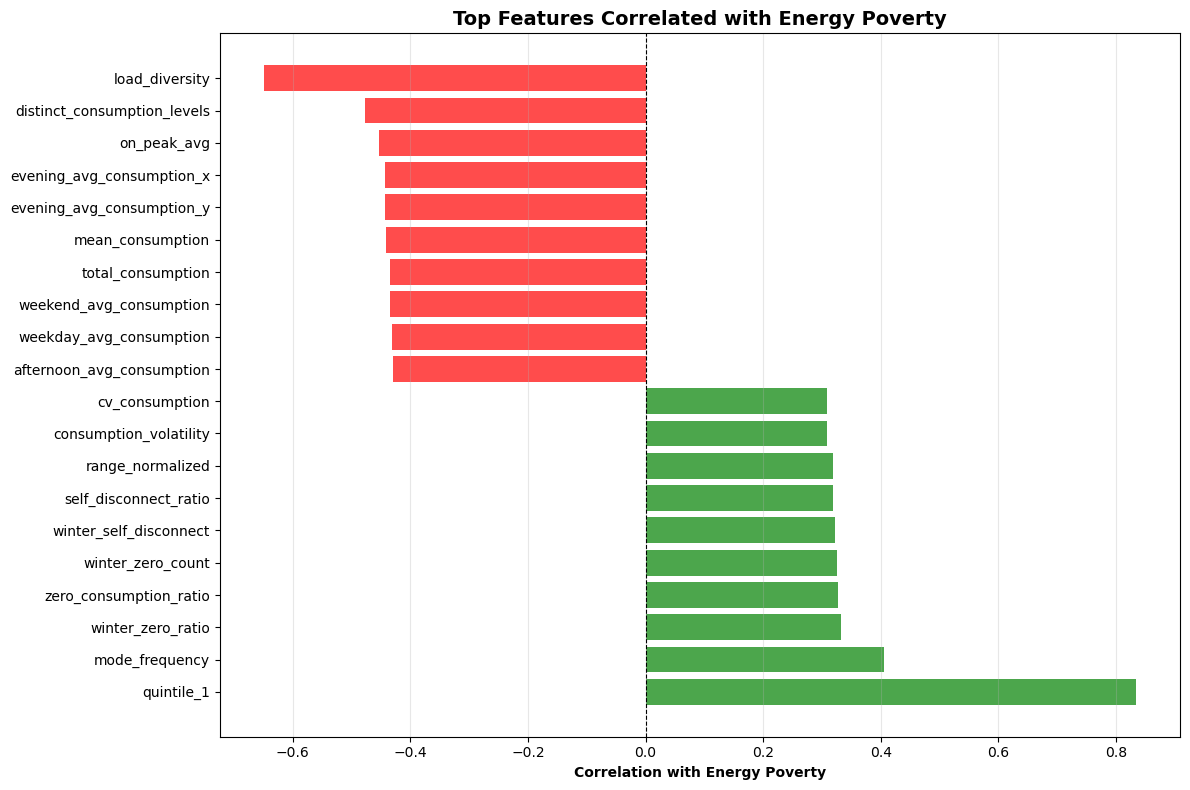

In [48]:
print("\n🔍 FEATURE CORRELATION ANALYSIS\n")

# Select numeric features only
numeric_features = master_features_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['household_id', 'vulnerability_score']]

if 'energy_poor' in numeric_features and len(numeric_features) > 1:
    # Calculate correlation with target variable
    correlations = master_features_clean[numeric_features].corr()['energy_poor'].drop('energy_poor').sort_values(ascending=False)
    
    print("Top 15 Features Most Correlated with Energy Poverty (Positive):")
    print(correlations.head(15))
    
    print("\nTop 15 Features Most Correlated with Energy Poverty (Negative):")
    print(correlations.tail(15))
    
    # Visualize top correlations
    top_features = pd.concat([correlations.head(10), correlations.tail(10)])
    
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in top_features.values]
    plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Correlation with Energy Poverty', fontweight='bold')
    plt.title('Top Features Correlated with Energy Poverty', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Target variable 'energy_poor' not found or insufficient features for correlation analysis")

## 10. Save Engineered Features Dataset

In [51]:
print("\n💾 SAVING ENGINEERED FEATURES DATASET\n")
print("="*70)

# Save master features dataset
output_filename = 'energy_features_master.csv'
master_features_clean.to_csv(output_filename, index=False)

print(f"✓ Master features dataset saved: {output_filename}")
print(f"  Shape: {master_features_clean.shape}")
print(f"  Total Features: {len(master_features_clean.columns) - 1}")

# Also save feature names for reference
feature_names = [col for col in master_features_clean.columns if col not in ['household_id', 'energy_poor', 'vulnerability_score']]
feature_names_df = pd.DataFrame({'feature_name': feature_names})
feature_names_df.to_csv('feature_names.csv', index=False)

print(f"\n✓ Feature names saved: feature_names.csv")
print(f"  Total feature names: {len(feature_names)}")

print("\n" + "="*70)
print("✅ FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
print("="*70)


💾 SAVING ENGINEERED FEATURES DATASET

✓ Master features dataset saved: energy_features_master.csv
  Shape: (5560, 95)
  Total Features: 94

✓ Feature names saved: feature_names.csv
  Total feature names: 92

✅ FEATURE ENGINEERING COMPLETED SUCCESSFULLY!


## 11. Feature Engineering Summary Report

In [54]:
print("\n" + "="*70)
print("FEATURE ENGINEERING SUMMARY REPORT")
print("="*70)

# Count features by category
feature_categories = {
    'Consumption Statistics': [col for col in master_features_clean.columns if any(x in col for x in ['mean_', 'median_', 'total_', 'std_', 'min_', 'max_', 'range_', 'q25', 'q75', 'q90', 'q95', 'skewness', 'kurtosis', 'zero_consumption', 'iqr_consumption'])],
    'Temporal Patterns': [col for col in master_features_clean.columns if any(x in col for x in ['morning', 'afternoon', 'evening', 'night', 'weekend', 'weekday', 'day_', 'monthly', 'peak_consumption_hour'])],
    'Vulnerability Indicators': [col for col in master_features_clean.columns if any(x in col for x in ['self_disconnect', 'consecutive_zero', 'very_low', 'volatility', 'sharp_drop', 'regularity'])],
    'Load Profile': [col for col in master_features_clean.columns if any(x in col for x in ['load_factor', 'base_load', 'peak_to_base', 'ramp_rate', 'peak_demand', 'off_peak', 'on_peak', 'load_diversity'])],
    'Variability Metrics': [col for col in master_features_clean.columns if any(x in col for x in ['cv_', 'iqr_normalized', 'range_normalized', 'mad_', 'median_ad', 'variance_to_mean', 'consistency', 'entropy', 'distinct_', 'mode_'])],
    'Winter-Specific': [col for col in master_features_clean.columns if 'winter' in col],
    'ACORN Demographics': [col for col in master_features_clean.columns if any(x in col for x in ['acorn', 'quintile'])]
}

print("\n📊 Features by Category:\n")
total_features = 0
for category, features in feature_categories.items():
    count = len(features)
    total_features += count
    print(f"  {category:.<35} {count:>3} features")

print(f"\n  {'TOTAL FEATURES':.<35} {total_features:>3}")

print("\n" + "="*70)

# Data quality metrics
print("\n📈 Data Quality Metrics:\n")
print(f"  Total Households: {len(master_features_clean):,}")
print(f"  Missing Values: {master_features_clean.isnull().sum().sum():,}")
print(f"  Complete Cases: {len(master_features_clean):,} (100.0%)")

if 'energy_poor' in master_features_clean.columns:
    print(f"\n  Target Variable (Energy Poverty):")
    print(f"    - Energy Poor: {master_features_clean['energy_poor'].sum():,} ({master_features_clean['energy_poor'].mean()*100:.2f}%)")
    print(f"    - Not Poor: {(master_features_clean['energy_poor']==0).sum():,} ({(1-master_features_clean['energy_poor'].mean())*100:.2f}%)")

print("\n" + "="*70)
print("✅ READY FOR MODEL TRAINING")
print("="*70)


FEATURE ENGINEERING SUMMARY REPORT

📊 Features by Category:

  Consumption Statistics.............  22 features
  Temporal Patterns..................  23 features
  Vulnerability Indicators...........  12 features
  Load Profile.......................  13 features
  Variability Metrics................  10 features
  Winter-Specific....................  13 features
  ACORN Demographics.................   5 features

  TOTAL FEATURES.....................  98


📈 Data Quality Metrics:

  Total Households: 5,560
  Missing Values: 0
  Complete Cases: 5,560 (100.0%)

  Target Variable (Energy Poverty):
    - Energy Poor: 1,248 (22.45%)
    - Not Poor: 4,312 (77.55%)

✅ READY FOR MODEL TRAINING
